In [1]:
import numpy as np
import pandas as pd
import optuna
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from typing import Union, Tuple
from scipy.special import logit
from scipy.stats import norm    
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, r2_score
import plotly.graph_objects as go
import lightgbm as lgb
import random

# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/WreJPgb9pJS687D). Пароль в канале курса.

In [2]:
df = pd.read_parquet('df.parquet.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ns](3), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [3]:
df.head()

,date,month,quarter,feature_217,feature_66,feature_9,feature_193,feature_15,feature_199,feature_25,...,feature_20,feature_188,feature_71,feature_106,feature_14,feature_92,feature_179,feature_102,target,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,1.180855,0.483118,13.976791,1.135021,43.271792,-46.888875,97.558366,...,23.745198,-32.001093,85.489903,1.454045,-195.725786,3.719083,1,-28.813537,0.0,train
478621,2021-01-01,2021-01-01,2021-01-01,3.427814,0.886778,27.158209,-0.378728,80.087863,-67.242703,105.803406,...,22.902111,-37.436243,71.735619,1.657242,-176.250404,3.277817,1,-45.987721,1.0,train
372254,2021-01-01,2021-01-01,2021-01-01,-38.555018,1.227175,19.893873,0.498787,98.464365,-67.402522,81.858076,...,21.848414,-51.872841,65.363236,1.626874,-178.116798,2.028950,0,-31.074122,1.0,train
2596,2021-01-01,2021-01-01,2021-01-01,-14.666558,0.753129,18.203010,-1.200014,117.331340,-25.557745,90.277266,...,26.134586,-49.703003,65.013659,1.170023,-192.232264,2.218177,1,-36.703897,0.0,train
216892,2021-01-01,2021-01-01,2021-01-01,6.734990,1.129100,11.245920,-0.108955,61.205722,-78.397406,82.637472,...,24.201039,-41.070219,69.986127,1.630795,-200.155528,3.055104,1,-44.672299,1.0,train


In [4]:
TARGET = 'target'
N_FEATURES = 230
RANDOM_STATE = 42
features = [f'feature_{i}' for i in range(N_FEATURES)]
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique` 

In [5]:
N_BUCKETS = 20

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    bucket_sizes = np.bincount(buckets)
    badrate = np.bincount(buckets, weights=target) / bucket_sizes
    
    badrate[badrate == 1] = 1 - 1e-3
    badrate[badrate == 0] = 1e-3
    z_quantile = norm.ppf(0.975)
    
    badrate_lower = badrate - z_quantile * np.sqrt((badrate * (1 - badrate)) / bucket_sizes)
    badrate_upper = badrate + z_quantile * np.sqrt((badrate * (1 - badrate)) / bucket_sizes)
    
    badrate_lower[badrate_lower <= 0] = 1e-3
    badrate_upper[badrate_upper >= 1] = 1 - 1e-3
    
    # переходим от бэдрейта к woe    
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)
    

    return woe, woe_lower, woe_upper

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    model = LogisticRegression(random_state=RANDOM_STATE)
    model.fit(values.reshape(-1, 1), target)
    proba = model.predict_proba(mean_feature.reshape(-1, 1))[:, 1]
    line = woe_transform(proba, offset)
    
    return line

def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""

    buckets_len = np.bincount(buckets)
    mean_feature = np.bincount(buckets, weights=values) / buckets_len
    
    offset = logit(sum(target) / len(target))
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset)
    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : calc_line(values, target, mean_feature, offset),
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

def calc_iv(buckets: np.ndarray, target: np.ndarray) -> int:
    
    offset = logit(sum(target) / len(target))
    woe, _, _ = woe_ci(target, buckets, offset)
    
    """Считает IV для признака"""
    total_bad = max(sum(target), 1e-8)
    total_good = max(len(target) - total_bad, 1e-8) #на случай если в каком то временном периоде (например месяце) будет только bad или только good
    
    backets_bad = np.bincount(buckets, weights=target) 
    backets_good = np.bincount(buckets, weights=[not t for t in target]) 
    IV = sum((backets_bad / total_bad - backets_good / total_good) * woe)
    return IV

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    
    buckets_info = calc_buckets_info(values, target, buckets)
    backets_woe = buckets_info["woe"]
    """Считает для признака roc auc, IV, R^2"""
    
    auc = roc_auc_score(target, values)

    # формула выше
    total_bad = sum(target)
    total_good = len(target) - total_bad
    
    backets_bad = np.bincount(buckets, weights=target) 
    backets_good = np.bincount(buckets, weights=[not t for t in target]) 
    IV = sum((backets_bad / total_bad - backets_good / total_good) * backets_woe)

    # Взвешенный R^2 
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    backets_len = np.bincount(buckets)

    R_sqr = r2_score(buckets_info["line"], backets_woe, sample_weight=backets_len)
    # R_sqr = r2_score(buckets_info["mean_feature"], backets_woe, sample_weight=backets_len)

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

values = np.array([1,1,10,3,4,5,2, 2])
target = np.array([0, 0, 1, 0, 0, 1, 0, 0])
buckets = calc_buckets(values, 3)
print(buckets)
calc_iv(buckets, target)


[0 0 2 1 1 2 0 0]


13.813509557297106

In [6]:
cat_features = df.columns[(df.dtypes == "object") | (df.nunique() < 100)]
cat_features = set(cat_features) - {"target"}
num_features = list(set(df.columns) - set(cat_features) - {"date"})
cat_features = list(cat_features) + ["date"]

print(f"cat_featues: {len(cat_features)}, num_features: {len(num_features)}, all_features: {len(df.columns)}")

cat_featues: 19, num_features: 216, all_features: 235


In [7]:
iv_num = pd.DataFrame(columns=["IV"])

for column in num_features:
    values = df[column].values
    buckets = calc_buckets(values, N_BUCKETS)
    iv_num.loc[column] = calc_iv(buckets, df['target'])
    
iv_num

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
C:\Users\USER\AppData\Local\Temp\ipykernel_19328\4218001052.py:25: RuntimeWarning: invalid value encountered in divide
  badrate = np.bincount(buckets, weights=target) / bucket_sizes
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib

,IV
feature_224,0.002609
feature_214,0.000137
feature_86,0.003486
feature_47,0.004839
feature_120,0.003081
...,...
feature_164,0.010212
feature_142,0.005351
feature_70,0.008749
feature_49,0.000155


In [8]:
iv_num[iv_num["IV"] < 0.005].sort_values("IV", ascending=False)

,IV
feature_123,0.004954
feature_47,0.004839
feature_146,0.004839
feature_156,0.004691
feature_138,0.004691
...,...
feature_116,0.000118
feature_20,0.000113
feature_176,0.000107
feature_229,0.000088


**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей?

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

Первая причина некорректности такого сравнения - разное колво бакетов, поскольку количество категорий может быть меньше 20. 
  
Также, для численных величин разбиение на бакеты выполняется таким образом, чтобы в каждой группе было одинаковое число элементов, а для категориальных, в связи с тем, что признак является дискретным разбиение идет по значениям категорий, и в каждой группе колво элементов может сильно отличаться

In [9]:
# your code here
iv_cat = pd.DataFrame(columns=["IV"])
for column in cat_features:
    values = df[column].values
    buckets = calc_buckets(values, min(df[column].nunique(), N_BUCKETS))
    iv_cat.loc[column] = calc_iv(buckets, df['target'])
iv_cat.sort_values("IV", ascending=False)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


,IV
feature_209,2.519535e-02
feature_144,1.336099e-02
feature_31,1.237389e-02
feature_140,1.146094e-02
feature_165,9.136224e-03
feature_147,7.958354e-03
feature_168,6.440163e-03
feature_62,6.243296e-03
feature_161,2.603480e-03
feature_10,1.374976e-03


In [10]:
inform_num_features = iv_num[iv_num["IV"] > 0.005].index
inform_cut_features = iv_cat[iv_cat["IV"] > 0.001].index
print(len(inform_num_features), len(inform_cut_features))

53 10


# Бустинг

## Подбор гиперпараметров бустинга (2 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [11]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = list(inform_cut_features) + list(inform_num_features)

In [12]:
features_optuna = np.array(sorted(features_optuna))
features_optuna

array(['feature_10', 'feature_100', 'feature_109', 'feature_111',
       'feature_114', 'feature_115', 'feature_117', 'feature_12',
       'feature_124', 'feature_132', 'feature_135', 'feature_139',
       'feature_140', 'feature_142', 'feature_144', 'feature_147',
       'feature_15', 'feature_154', 'feature_155', 'feature_161',
       'feature_162', 'feature_164', 'feature_165', 'feature_167',
       'feature_168', 'feature_170', 'feature_172', 'feature_183',
       'feature_2', 'feature_206', 'feature_209', 'feature_213',
       'feature_218', 'feature_223', 'feature_225', 'feature_227',
       'feature_23', 'feature_24', 'feature_26', 'feature_27',
       'feature_30', 'feature_31', 'feature_32', 'feature_35',
       'feature_36', 'feature_38', 'feature_39', 'feature_4',
       'feature_43', 'feature_44', 'feature_46', 'feature_5',
       'feature_56', 'feature_62', 'feature_70', 'feature_75',
       'feature_76', 'feature_79', 'feature_9', 'feature_94',
       'feature_96', 'featu

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [13]:
def objective(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves',2, 200),
#         'n_estimators': trial.suggest_int('n_estimators',100, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        'min_child_samples': trial.suggest_int('min_child_samples',15,30),
        'reg_lambda' : trial.suggest_float('reg_lambda',0.001,1, log=True),
        'reg_alpha' : trial.suggest_float('reg_alpha',0.001,1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        #####
        'random_state': RANDOM_STATE
    }

    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )
    
    return auc_valid

In [14]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)


[I 2024-04-05 22:40:19,409] A new study created in memory with name: no-name-6cbbcd68-04bf-47ba-8076-c06de6970987


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-04-05 22:40:42,916] Trial 2 finished with value: 0.6963801121903836 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.035909587230181464, 'num_leaves': 17, 'n_estimators': 149, 'min_child_samples': 28, 'reg_lambda': 0.3249248034553731, 'reg_alpha': 0.05448222040151043, 'subsample': 0.8327728659281177, 'colsample_bytree': 0.32954234625305484, 'max_depth': 5}. Best is trial 2 with value: 0.6963801121903836.
[I 2024-04-05 22:40:52,692] Trial 11 finished with value: 0.6533769868868383 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.0016456048846412465, 'num_leaves': 58, 'n_estimators': 316, 'min_child_samples': 29, 'reg_lambda': 0.0016537056090138258, 'reg_alpha': 0.001484494007238385, 'subsample': 0.4914131006754939, 'colsample_bytree': 0.498480903228169, 'max_depth': 4}. Best is trial 2 with value: 0.6963801121903836.
[I 2024-04-05 22:40:55,952] Trial 10 finished with value: 0.6850206041767849 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.01

У меня optuna каждый раз выдает разные результаты, несмотря на то что я вроде бы везде фиксирую state,   
поэтому чтобы не линеаризовывать новые фичи я фиксирую найденные мной ранее параметры  
  
{'boosting_type': 'gbdt', 'learning_rate': 0.0980917091966749, 'num_leaves': 89, 'n_estimators': 317, 'min_child_samples': 25, 'reg_lambda': 0.06800454849267329, 'reg_alpha': 0.014317816574271242, 'subsample': 0.10915807007892572, 'colsample_bytree': 0.4863966742021898, 'max_depth': 7}


In [17]:
study.best_params

{'boosting_type': 'gbdt', 'learning_rate': 0.0980917091966749, 'num_leaves': 89, 'n_estimators': 317, 'min_child_samples': 25, 'reg_lambda': 0.06800454849267329, 'reg_alpha': 0.014317816574271242, 'subsample': 0.10915807007892572, 'colsample_bytree': 0.4863966742021898, 'max_depth': 7}


In [18]:
# clf = LGBMClassifier(**study.best_params)
clf = LGBMClassifier(**{'boosting_type': 'gbdt', 
                        'learning_rate': 0.0980917091966749, 
                        'num_leaves': 89, 
                        'n_estimators': 317, 
                        'min_child_samples': 25, 
                        'reg_lambda': 0.06800454849267329, 
                        'reg_alpha': 0.014317816574271242, 
                        'subsample': 0.10915807007892572, 
                        'colsample_bytree': 0.4863966742021898, 
                        'max_depth': 7})
clf.random_state = RANDOM_STATE
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
print(auc_test)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'

0.7285682027700948


## Кривые накопления (1 балл)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`. 

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

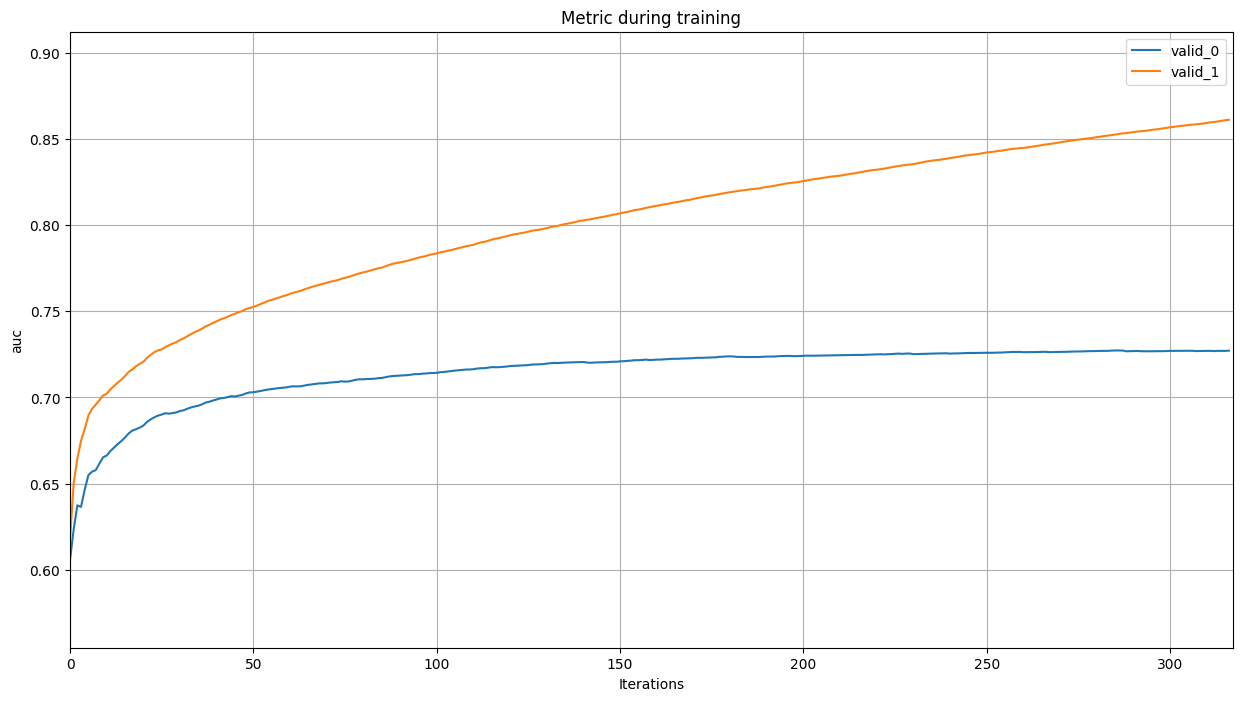

In [19]:
#####
# <your code here>
# clf = LGBMClassifier(**study.best_params, n_jobs=-1)
clf=  LGBMClassifier(**{'boosting_type': 'gbdt', 
                        'learning_rate': 0.0980917091966749, 
                        'num_leaves': 89, 
                        'n_estimators': 317, 
                        'min_child_samples': 25, 
                        'reg_lambda': 0.06800454849267329, 
                        'reg_alpha': 0.014317816574271242, 
                        'subsample': 0.10915807007892572, 
                        'colsample_bytree': 0.4863966742021898, 
                        'max_depth': 7})


clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    eval_set=[(df.loc[df['sample_part'] == 'test', features_optuna], df.loc[df['sample_part'] == 'test', 'target']),
              (df.loc[df['sample_part'] == 'train', features_optuna], df.loc[df['sample_part'] == 'train', 'target'])],
    eval_metric="auc",
    verbose=0
)
lgb.plot_metric(clf, metric="auc", figsize=(15, 8))
#####

**Вопрос:** Что вы видите на полученных графиках? 

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте.

Зависит от того считать ли изменения в auc во втором знаке после запятой существенными. Видно, что рост метрики с течением времени замедляется и выходит на плато, однако все равно наибольшее значение метрики достигается на последних итерациях. Если скорость ответа нам не важна, то можно ничего не делать, однако если мы не хотим долго ждать чтобы на сотые процента увеличить метрику, то можно обрезать количество деревьев при выходе метркии на плато. (В общем зависит от задачи, заказчик сам определеят соотношение времени/скорости ответа)

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

<Axes: title={'center': 'LightGBM Feature Importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

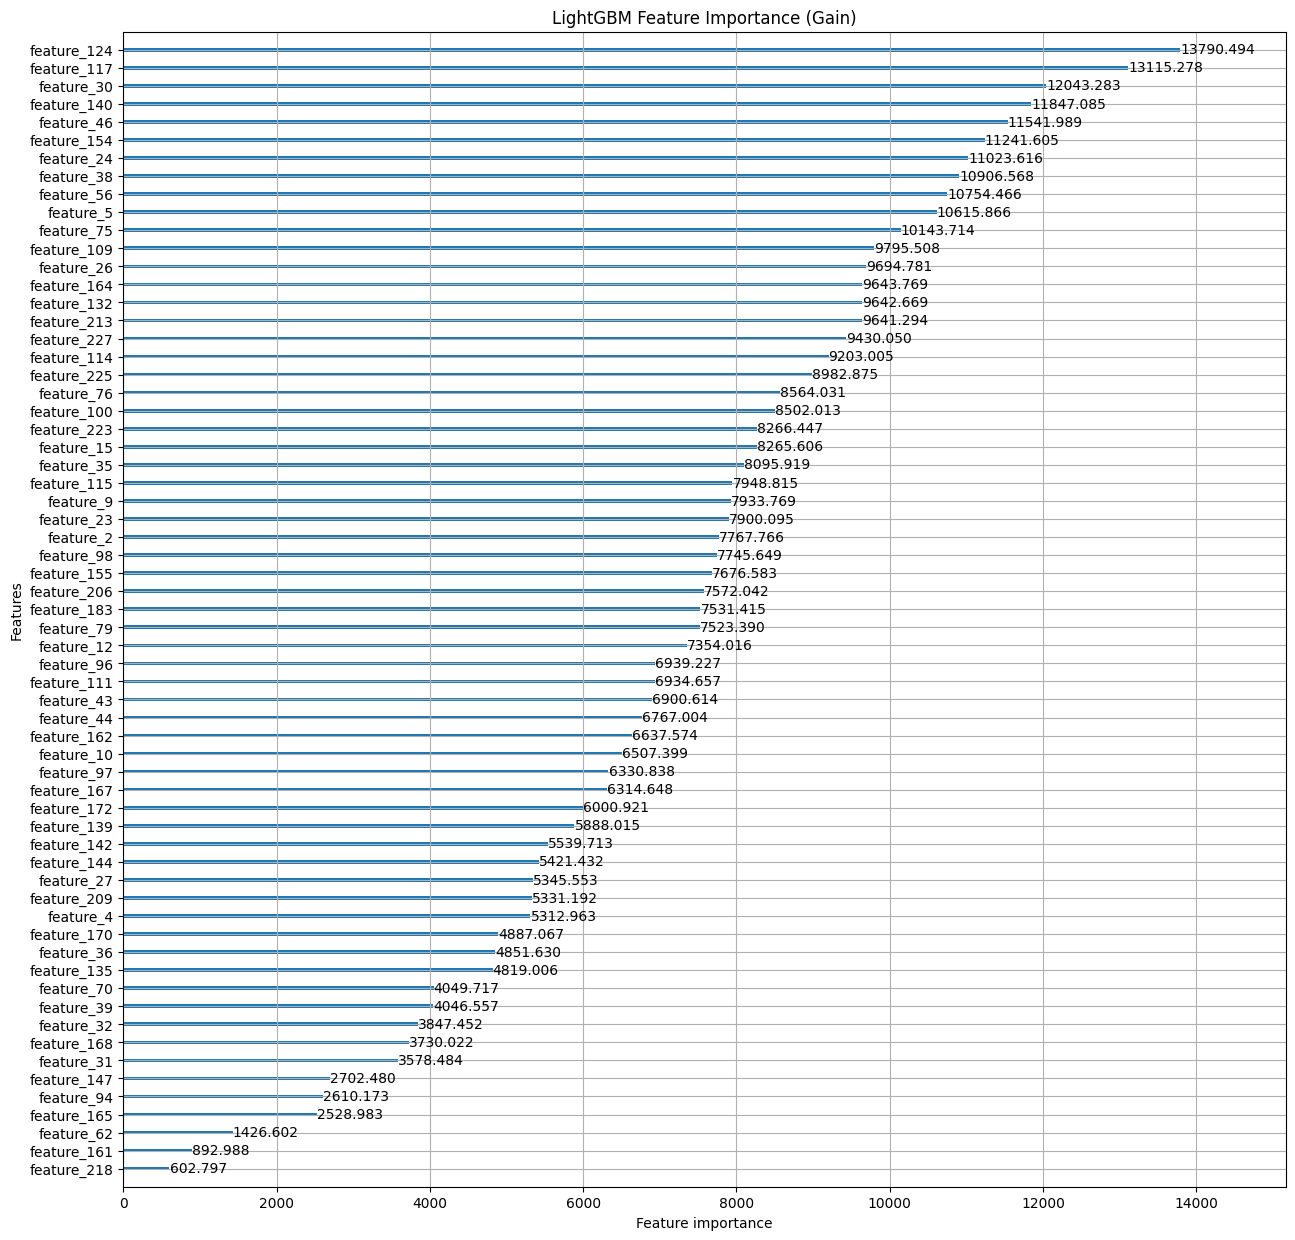

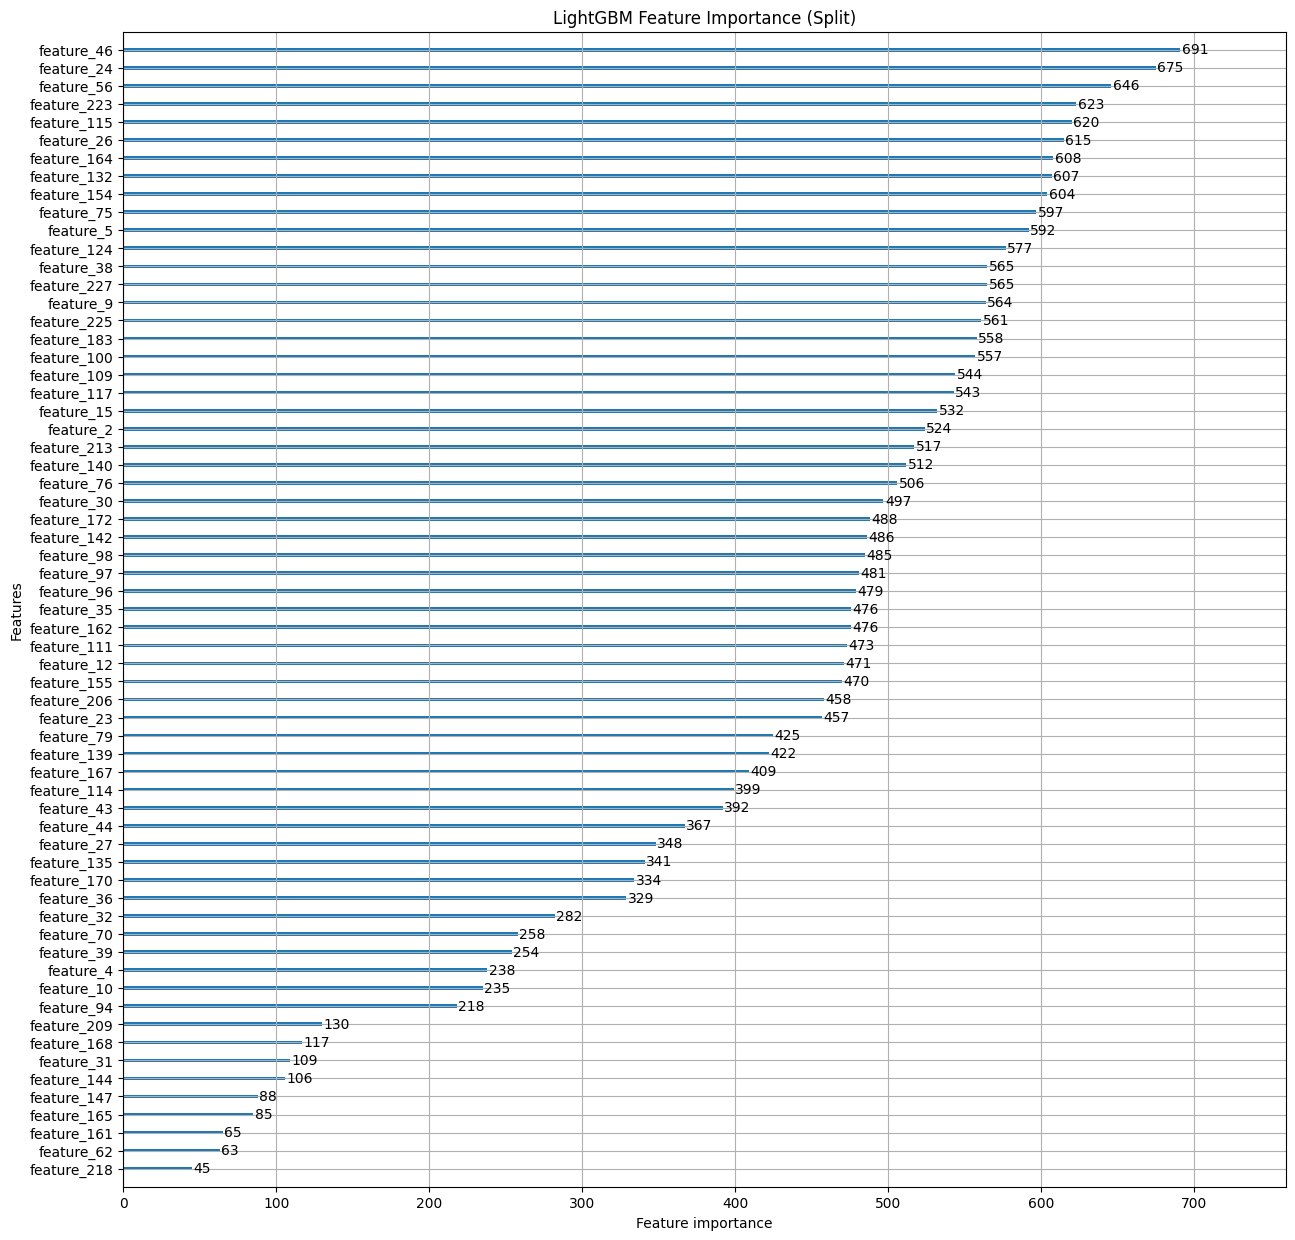

In [20]:
#####
# <your code here>
lgb.plot_importance(clf, importance_type="gain", figsize=(15,15), title="LightGBM Feature Importance (Gain)")
lgb.plot_importance(clf, importance_type="split", figsize=(15,15), title="LightGBM Feature Importance (Split)")

#####

**Вопрос:** Какие выводы можно сделать из полученных графиков?

Гистограммы для split и для gain отличаются, например feature_124 по gain является самой важной, а по split стоит лишь на 12 месте. У всех признаков вклад не нулевой. В целом тренды по обоим гистограмма похожи

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно: 
- массив значений фичи, 
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [21]:
import plotly.graph_objects as go

In [22]:
from sklearn.metrics import roc_auc_score


def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    
    data = pd.DataFrame({'values': values, 'target': target, 'time': time})
    data = data.dropna()
    
    if metric == 'IV':
        data['buckets'] = data.groupby('time')['values'].transform(lambda x: calc_buckets(x, n_buckets_for_IV))
        metric_per_time_period = data.groupby('time').apply(lambda x: calc_iv(x['buckets'].values, x['target'].values))
        
    elif metric == 'roc_auc':
        metric_per_time_period = data.groupby('time').apply(lambda x: roc_auc_score(x['target'], x['values']))
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    # your code here

    plot_title = f"{values.name}, {metric} in time"
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=time.unique(), # месяцы или кварталы, your code here
            y=metric_per_time_period, # аггрегированное значение метрики, your code here
            mode='markers+lines',
            name=values.name# имя фичи, your code here
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals=time.unique()# месяцы или кварталы, your code here
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()

    # return fig

In [23]:
# примерно так это должно будет выглядеть
plot_metric_time(df["feature_223"], df['target'], df['quarter'], metric='IV') # 

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [120]:
# your code here
feature_importance = clf.booster_.feature_importance(importance_type='gain')
names = clf.booster_.feature_name()
gain_features_importance = pd.DataFrame({"names": names, "feature_importance": feature_importance})
top_gain_features = gain_features_importance.sort_values("feature_importance", ascending=False)["names"].values[:17]
print(top_gain_features)

for feature in top_gain_features:
    plot_metric_time(df[feature], df['target'], df['quarter'])

['feature_124' 'feature_117' 'feature_30' 'feature_140' 'feature_46'
 'feature_154' 'feature_24' 'feature_38' 'feature_56' 'feature_5'
 'feature_75' 'feature_109' 'feature_26' 'feature_164' 'feature_132'
 'feature_213' 'feature_227']


In [121]:
unstable_features = ["feature_154"] #feature_117 feature_132 feature_227 mb

На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [122]:
df_for_logreg = df[list(set(top_gain_features) - set(unstable_features)) + ['date', 'month', 'quarter', 'target', 'sample_part']]

In [123]:
df_for_logreg.columns

Index(['feature_75', 'feature_109', 'feature_26', 'feature_132', 'feature_5',
       'feature_213', 'feature_38', 'feature_46', 'feature_56', 'feature_227',
       'feature_117', 'feature_24', 'feature_164', 'feature_30', 'feature_124',
       'feature_140', 'date', 'month', 'quarter', 'target', 'sample_part'],
      dtype='object')

## Предобработка признаков (2 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бактеами

In [124]:
logreg_cat_features = []
logreg_num_features = []

for feature in df_for_logreg.columns:
    if feature in cat_features:
        logreg_cat_features.append(feature)
    if feature in num_features:
        logreg_num_features.append(feature)
print("logreg_cat_features: ", logreg_cat_features)
print("logreg_num_features: ", logreg_num_features)

logreg_cat_features:  ['feature_140', 'date', 'month', 'quarter', 'sample_part']
logreg_num_features:  ['feature_75', 'feature_109', 'feature_26', 'feature_132', 'feature_5', 'feature_213', 'feature_38', 'feature_46', 'feature_56', 'feature_227', 'feature_117', 'feature_24', 'feature_164', 'feature_30', 'feature_124', 'target']


In [125]:
df_for_logreg.isnull().sum()

feature_75         0
feature_109        0
feature_26         0
feature_132        0
feature_5          0
feature_213        0
feature_38         0
feature_46         0
feature_56         0
feature_227        0
feature_117        0
feature_24         0
feature_164        0
feature_30     34475
feature_124    58984
feature_140    36943
date               0
month              0
quarter            0
target             0
sample_part        0
dtype: int64

In [126]:
def sign_pow(values, pow):
    return np.abs(values) ** pow * np.sign(values)

### Линеаризацию feature_109

In [127]:
woe_line(df_for_logreg["feature_109"].values, df_for_logreg["target"].values, N_BUCKETS)

In [50]:
woe_line(sign_pow(df_for_logreg["feature_109"].values / 3 + 25,  3), df_for_logreg["target"].values, N_BUCKETS)

### линераизация feature_164

In [60]:
woe_line(df_for_logreg["feature_164"].values, df_for_logreg["target"].values, N_BUCKETS)

In [61]:
coeff = [-0.05876058, 1.29808386, 8.62163345, 0.01] # мега подбор коэфициентов полинома слоабой степени через генетику
def f(x, vec):
    result = 0
    for i in range(len(vec)):
        result += vec[i] * (x ** i)
    return result

woe_line(f(df_for_logreg["feature_164"].values, coeff), df_for_logreg["target"].values, N_BUCKETS)

### линеаризация feature_117

In [62]:
# your code here
woe_line(df_for_logreg["feature_117"].values, df_for_logreg["target"], N_BUCKETS)

### Линераизация feature_213

In [204]:
woe_line(df_for_logreg['feature_213'].values, df_for_logreg['target'].values, N_BUCKETS)

In [ ]:
df_for_logreg['feature_213'].quantile([0.03, 0.97])

0.03     5.367503
0.97    18.144435
Name: feature_213, dtype: float64

In [ ]:
# woe_line(np.log(np.clip(df_for_logreg['feature_213'].values, 1, 100)), df_for_logreg['target'].values, N_BUCKETS)
# woe_line(np.log(np.clip(df_for_logreg['feature_213'].values, 1, 100)) ** (1/2), df_for_logreg['target'].values, N_BUCKETS)
# woe_line(1/(np.clip(df_for_logreg['feature_213'].values, 1, 100)), df_for_logreg['target'].values, N_BUCKETS)
# woe_line((np.clip(df_for_logreg['feature_213'].values, 5, 17))**(-1.7), df_for_logreg['target'].values, N_BUCKETS)
# woe_line((np.clip(df_for_logreg['feature_213'].values, 5, 15))**(-1.7), df_for_logreg['target'].values, N_BUCKETS)
woe_line(np.cos((df_for_logreg['feature_213'].values.clip(6, 100) - 13.5) * np.pi / 33).clip(0.7), df_for_logreg['target'].values, N_BUCKETS)

In [ ]:
# df[df['feature_213'].notna(), 'feature_213'] = ((df.feature_213.values -17)**3).clip(-10418.025455,-13.838094)
# woe_line(np.sin((df_for_logreg["feature_213"].values - 12 -4)/8 * np.pi), df_for_logreg['target'].values, N_BUCKETS)
# woe_line(np.cos((df_for_logreg['feature_213'].values.clip(6, 100) - 12.5) * np.pi /15).clip(0.7), df_for_logreg['target'].values, N_BUCKETS)
woe_line(((df_for_logreg["feature_213"].values - 17)**3).clip(-100000000, -15), df_for_logreg.target.values, N_BUCKETS)

### Линераизация feature_75

In [ ]:
woe_line(df_for_logreg['feature_75'].values, df_for_logreg['target'].values, N_BUCKETS)

### Линеаризация feature_46

In [ ]:
woe_line(df_for_logreg['feature_46'].values, df_for_logreg['target'].values, N_BUCKETS)

In [ ]:
print((df_for_logreg["feature_46"] ).quantile(0.03))
print((df_for_logreg["feature_46"] ).quantile(0.97))
print(df_for_logreg["feature_46"].min())
print(df_for_logreg["feature_46"].max())

-319.58899158910674
454.54961224550715
-887.0932802279513
1068.583133515357


In [ ]:
# woe_line(np.sin(np.pi * ((df_for_logreg['feature_46'].values.clip(-271, 454) - 91.5))/429), df_for_logreg.target, N_BUCKETS)
woe_line((((df_for_logreg['feature_46'].values)/20+20)**3).clip(5500, 78000), df_for_logreg["target"].values, N_BUCKETS)

### Линеаризация feature_24

In [ ]:
woe_line(df_for_logreg["feature_24"].values, df_for_logreg["target"].values, N_BUCKETS)

### Линеаризация feature_30

In [ ]:
woe_line(df_for_logreg['feature_30'].dropna().values, df_for_logreg.loc[df_for_logreg["feature_30"].isna() == False, "target"].values, N_BUCKETS)

In [ ]:
woe_line(np.log(df_for_logreg['feature_30'].dropna().values), df_for_logreg.loc[df_for_logreg["feature_30"].isna() == False, "target"].values, N_BUCKETS)

### Линеаризация feature_26

In [64]:
woe_line(df_for_logreg["feature_26"].values, df_for_logreg["target"].values, N_BUCKETS)

In [65]:
woe_line(sign_pow(np.clip(df_for_logreg["feature_26"].values, -390, 160)+165, 0.6), df_for_logreg["target"].values, N_BUCKETS)

In [66]:
woe_line(sign_pow(df_for_logreg['feature_26'].clip(-390, 160).values + 195, 0.63), df_for_logreg.target, N_BUCKETS)

### Линеаризация feature_5

In [67]:
woe_line(df_for_logreg["feature_5"].values, df_for_logreg["target"].values, N_BUCKETS)

In [68]:
print((df_for_logreg["feature_5"] ).quantile(0.05))
print((df_for_logreg["feature_5"] ).quantile(0.95))
print(df_for_logreg["feature_5"].min())
print(df_for_logreg["feature_5"].max())

-229.3674292176964
-95.98656082055794
-352.13616426352354
34.744768691864834


In [69]:
# woe_line(((df_for_logreg["feature_5"].values.clip(-230, -80) + 240)**2), df_for_logreg["target"], N_BUCKETS)
val = df_for_logreg["feature_5"].values + 90

woe_line(np.sin(val * np.pi/179), df_for_logreg.target, N_BUCKETS)

### Линеаризация feature_132

In [70]:
woe_line(df_for_logreg["feature_132"].values, df_for_logreg["target"], N_BUCKETS)

In [71]:
# woe_line(np.cos(np.pi*(sign_pow(df_for_logreg["feature_132"].values, 1/2)/60 + 16.07)), df_for_logreg["target"], N_BUCKETS)
woe_line(df_for_logreg["feature_132"].values ** 2, df_for_logreg["target"], N_BUCKETS)

### Линаризиация feature_56

In [72]:
woe_line(df_for_logreg["feature_56"].values, df_for_logreg["target"].values, N_BUCKETS)

In [73]:
print((df_for_logreg["feature_56"] ).quantile(0.03))
print((df_for_logreg["feature_56"] ).quantile(0.97))
print(df_for_logreg["feature_56"].min())
print(df_for_logreg["feature_56"].max())

-464.8300102052425
284.270709002505
-972.8079626558734
865.4986613588197


In [74]:
woe_line(df_for_logreg["feature_56"].values.clip(-464, 284)**2, df_for_logreg["target"].values, N_BUCKETS)

### Линеаризация feature_124

In [75]:
print((df_for_logreg["feature_124"]).quantile(0.03))
print((df_for_logreg["feature_124"]).quantile(0.97))
print(df_for_logreg["feature_124"].min())
print(df_for_logreg["feature_124"].max())

-63.26675398781491
-20.953899403206744
-97.7546688342153
15.656462614583223


In [76]:
woe_line(df_for_logreg["feature_124"].dropna().values, df_for_logreg.loc[df_for_logreg["feature_124"].isna() == False, "target"].values, N_BUCKETS)

In [77]:
woe_line(sign_pow(df_for_logreg["feature_124"].dropna().values.clip(-1000000, -20), 2), df_for_logreg.loc[df_for_logreg["feature_124"].isna() == False, "target"].values, N_BUCKETS)

### Лиенаризация feature_38

In [78]:
woe_line(df_for_logreg["feature_38"].values, df_for_logreg["target"], N_BUCKETS)

In [79]:
print((df_for_logreg["feature_38"]).quantile(0.05))
print((df_for_logreg["feature_38"]).quantile(0.97))
print(df_for_logreg["feature_38"].min())
print(df_for_logreg["feature_38"].max())

45.93150610053125
131.2566819799439
-13.179805365022146
201.65056345819426


In [80]:
woe_line(df_for_logreg["feature_38"].values.clip(0, 100000) ** 2, df_for_logreg["target"], N_BUCKETS)

### Линеаризация feature_227

In [200]:
woe_line(df_for_logreg["feature_227"].values, df_for_logreg["target"].values, N_BUCKETS)

In [201]:
woe_line(((df_for_logreg["feature_227"].values)**2).clip(-1000, 370000), df_for_logreg["target"].values, N_BUCKETS)

### Линеаризация feature_98

In [ ]:
woe_line(df_for_logreg["feature_98"].values, df_for_logreg["target"].values, N_BUCKETS)

Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков?

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их)

**Мой ответ**: В идеальном случаи заполнение признаков не должно менять характера зависимости между нашей переменной и таргетом, а также не должно изменять распределение нашего признака.  
Заполнение средним точно меняет распределение признака, однако в некоторых случаях оно может быть особенно плохим, например когда распределение сильно смещенное и имеет длинный хвост. В этом случаи медиана и среднее сильно расходяться, и при заполнении средним медиана растет. Пример - распределение доходов. Среднее распределения находиться существенно правее медианы и поэтому если предположить что пропуски в данных появляются случайно, странно предполагать что случайный человек получает зп выше медианной. Альтернативой может служить заполнение пропущенных значений с помощью knn или регрессии на пропущенную переменную, однако второй способ в нашем случаи точно не подходит т.к ведет к линейной зависимости. knn просто медленный  
P.S у нас в данных есть категориальный признак feature_140 с пропущенными значениями, их я кодирую как отдельную категорию


In [ ]:
df_for_logreg.isna().sum()

feature_75         0
feature_109        0
feature_26         0
feature_132        0
feature_46         0
feature_56         0
feature_5          0
feature_117        0
feature_38         0
feature_24         0
feature_164        0
feature_30     34475
feature_124    58984
feature_140    36943
date               0
month              0
quarter            0
target             0
sample_part        0
dtype: int64

### распределения до заполнения 

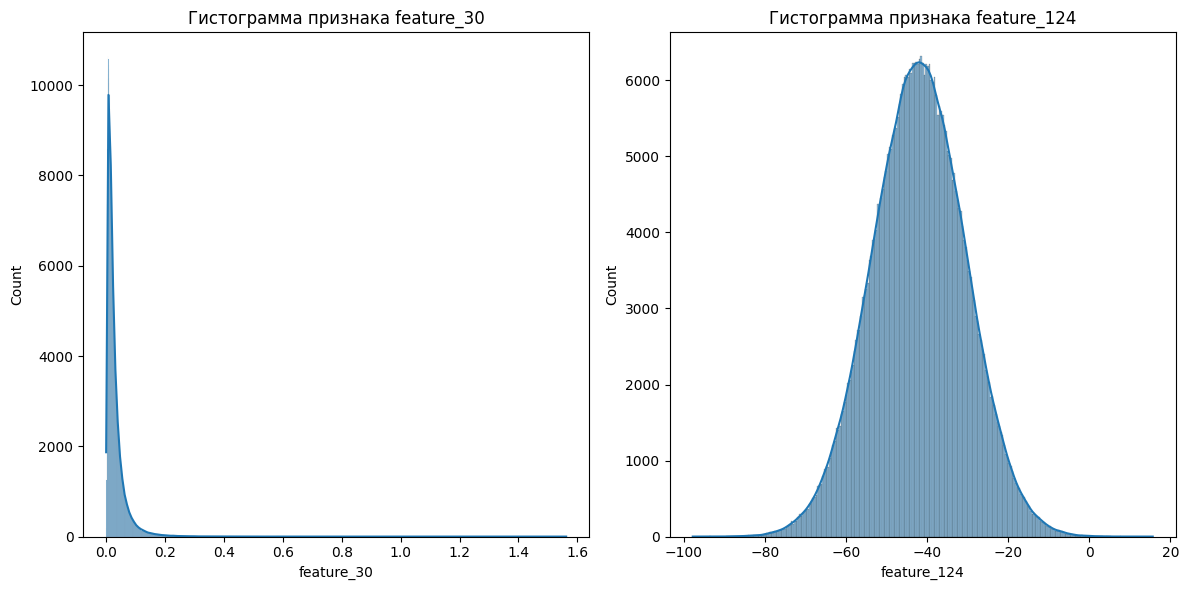

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df_for_logreg["feature_30"], ax=ax[0], kde=True)
ax[0].set_title('Гистограмма признака feature_30')

sns.histplot(df_for_logreg["feature_124"], ax=ax[1], kde=True)
ax[1].set_title('Гистограмма признака feature_124')

plt.tight_layout()
plt.show()

In [148]:
from sklearn.neighbors import KNeighborsRegressor


def knn_impute(df: pd.DataFrame, na_target: str, num_features: list) -> pd.DataFrame:
    numeric_df = df[num_features]
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor(n_jobs=-1)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df


df_for_logreg.loc[:, "feature_30"] = knn_impute(df_for_logreg, "feature_30", logreg_num_features[:-1])
df_for_logreg.loc[:, "feature_124"] = knn_impute(df_for_logreg, "feature_124", logreg_num_features[:-1])

C:\Users\USER\AppData\Local\Temp\ipykernel_19328\4039488392.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_19328\4039488392.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### распределения после заполнения 
(не изменились)

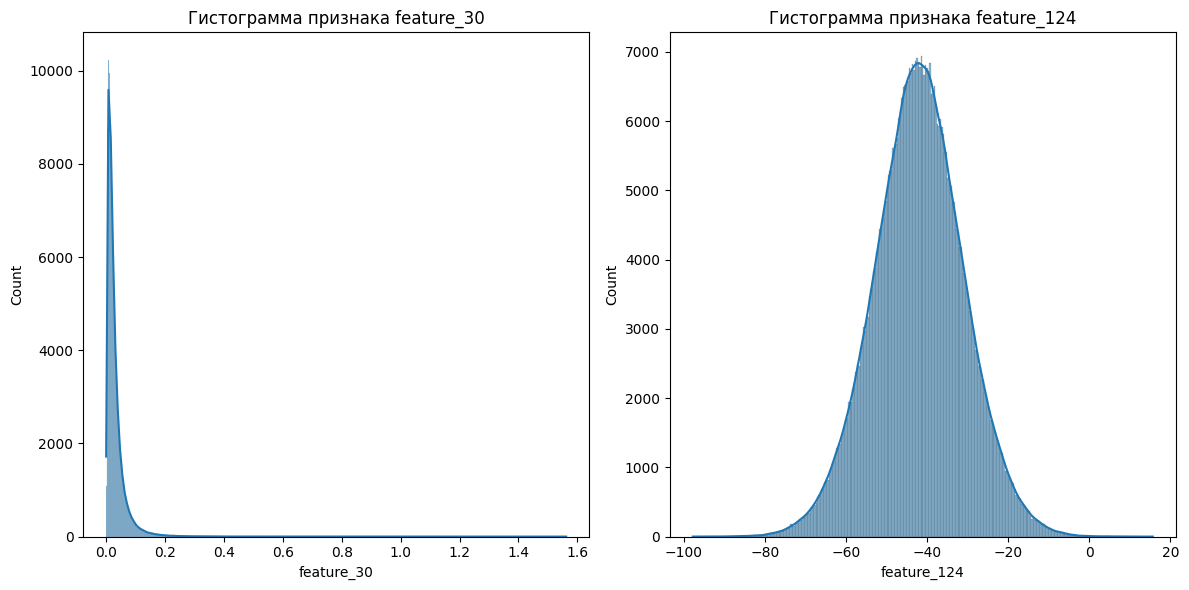

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df_for_logreg["feature_30"], ax=ax[0], kde=True)
ax[0].set_title('Гистограмма признака feature_30')

sns.histplot(df_for_logreg["feature_124"], ax=ax[1], kde=True)
ax[1].set_title('Гистограмма признака feature_124')

plt.tight_layout()
plt.show()

Характер зависимости от таргета также не изменился

In [202]:
woe_line(df_for_logreg["feature_30"].values, df_for_logreg["target"].values, N_BUCKETS)

In [203]:
woe_line(df_for_logreg["feature_124"].values, df_for_logreg["target"].values, N_BUCKETS)

In [58]:
df_for_logreg.isna().sum()

feature_75         0
feature_109        0
feature_26         0
feature_132        0
feature_46         0
feature_56         0
feature_5          0
feature_117        0
feature_38         0
feature_24         0
feature_164        0
feature_30         0
feature_124        0
feature_140    36943
date               0
month              0
quarter            0
target             0
sample_part        0
dtype: int64

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

In [99]:
logreg_cat_features.remove("sample_part")
logreg_cat_features.remove("date")
logreg_cat_features

['feature_140', 'month', 'quarter']

In [100]:
df_for_logreg.columns

Index(['feature_75', 'feature_109', 'feature_26', 'feature_132', 'feature_46',
       'feature_56', 'feature_5', 'feature_117', 'feature_38', 'feature_24',
       'feature_164', 'feature_30', 'feature_124', 'feature_140', 'date',
       'month', 'quarter', 'target', 'sample_part'],
      dtype='object')

In [168]:
def linearize_woe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    # df["feature_213"] = (np.clip(df['feature_213'].values, 5, 17))**(-1.7) хуже
    # df["feature_213"] = np.cos((df['feature_213'].values.clip(6, 100) - 12.5) * np.pi / 20) #0.955 хуже
    # df["feature_213"] = (np.clip(df['feature_213'].values, 5, 15))**(-1.7)
    # df['feature_213'] = np.cos((df['feature_213'].values.clip(6, 100) - 12.5) * np.pi / 20).clip(0.5, 1)
    # df['feature_213'] =  np.cos((df['feature_213'].values.clip(6, 100) - 13) * np.pi / 35).clip(0.7)
    # df['feature_213'] = np.cos((df['feature_213'].values.clip(6, 100) - 13.5) * np.pi / 33).clip(0.7) #лучшая линеаризация r2=0.983, iv = 0.006
    df['feature_213'] = ((df["feature_213"].values - 17)**3).clip(-100000000, -15) #best

    
    # df['feature_46'] = np.sin(np.pi * ((df['feature_46'].values.clip(-271, 454) - 91.5))/429) #0.888 xуже
    df["feature_46"] = (((df_for_logreg['feature_46'].values)/20+20)**3).clip(5500, 78000) 

    df["feature_30"] = np.log(df['feature_30'].values)
    
    # df["feature_26"] = sign_pow(np.clip(df["feature_26"].values, -390, 160)+165, 0.6)
    # df["feature_26"] = sign_pow(df['feature_26'].clip(-390, 160).values + 179, 0.67)
    df["feature_26"]  = (sign_pow(df['feature_26'].clip(-390, 160).values + 195, 0.63)).clip(-9, 35)
    
    # df["feature_5"] = np.cos(np.pi * (df["feature_5"].values.clip(-229, -80) + 160 + 5)/350) #0.906 0.002
    # df["feature_5"] = np.sin((df_for_logreg["feature_5"].values + 100) * np.pi/160)
    df["feature_5"] = np.sin((df_for_logreg["feature_5"].values + 90) * np.pi/179)

    df["feature_132"] = df["feature_132"].values ** 2 #0.97  0.06
    # df["feature_132"] =  np.cos(np.pi*(sign_pow(df["feature_132"].values, 1/2)/60 + 16.07)) # 0.88, 0.08 -хуже

    df["feature_56"] = df["feature_56"].values.clip(-464, 284)**2
    
    df["feature_124"] = sign_pow(df["feature_124"].values.clip(-1000000, -20), 2)
    
    df["feature_38"] = df["feature_38"].values.clip(0, 100000) ** 2
    
    df["feature_227"] = (df["feature_227"].values - 90)**2    
    # df["feature_227"] = (df["feature_227"].values)**2 
    
    df["feature_109"] = sign_pow(df["feature_109"].values / 3 + 25,  3)
    
    df["feature_164"] = f(df_for_logreg["feature_164"].values, coeff)

    return df
# 46 5 213 проблемы
transformed_logreg_df = linearize_woe(df_for_logreg)

In [169]:
transformed_logreg_df.columns

Index(['feature_75', 'feature_109', 'feature_26', 'feature_132', 'feature_5',
       'feature_213', 'feature_38', 'feature_46', 'feature_56', 'feature_227',
       'feature_117', 'feature_24', 'feature_164', 'feature_30', 'feature_124',
       'feature_140', 'date', 'month', 'quarter', 'target', 'sample_part',
       'logreg', 'logit_logreg'],
      dtype='object')

In [170]:
df_for_logreg.isnull().sum()

feature_75          0
feature_109         0
feature_26          0
feature_132         0
feature_5           0
feature_213         0
feature_38          0
feature_46          0
feature_56          0
feature_227         0
feature_117         0
feature_24          0
feature_164         0
feature_30          0
feature_124         0
feature_140     36943
date                0
month               0
quarter             0
target              0
sample_part         0
logreg              0
logit_logreg        0
dtype: int64

In [171]:
df_for_logreg

,feature_75,feature_109,feature_26,feature_132,feature_5,feature_213,feature_38,feature_46,feature_56,feature_227,...,feature_30,feature_124,feature_140,date,month,quarter,target,sample_part,logreg,logit_logreg
22620,-37.566036,-20.603835,45.123716,-51.036000,-215.945717,7.458468,81.613713,115.319640,-258.724816,-173.334454,...,0.036732,-61.495238,15.0,2021-01-01,2021-01-01,2021-01-01,0.0,train,0.559493,0.239105
478621,-51.686117,-25.523515,33.405854,-12.897176,-170.713568,10.884534,64.991683,172.981221,-75.131292,-479.616136,...,0.059557,-28.477404,28.0,2021-01-01,2021-01-01,2021-01-01,1.0,train,0.717719,0.933175
372254,-32.603922,-30.064426,-186.825975,-42.238052,-154.503339,17.206131,45.298801,-119.580242,-270.127459,-222.993621,...,0.083588,-36.557099,10.0,2021-01-01,2021-01-01,2021-01-01,1.0,train,0.670174,0.708971
2596,-45.032987,-37.356662,-74.749292,-21.097818,-131.553444,18.618423,41.407761,85.009499,-463.492274,312.396421,...,0.021008,-42.117574,22.0,2021-01-01,2021-01-01,2021-01-01,0.0,train,0.657772,0.653380
216892,-58.049155,-38.641177,186.120862,-21.926765,-162.092621,8.274292,104.813062,43.108790,327.178077,-201.997489,...,0.090340,-48.599477,50.0,2021-01-01,2021-01-01,2021-01-01,1.0,train,0.692542,0.812029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196513,-38.487619,-27.467429,117.733537,-1.478616,-160.271802,8.779791,102.181440,266.894924,-24.123456,-514.478905,...,0.024842,-34.698016,23.0,2022-12-30,2022-12-01,2022-10-01,1.0,test,0.722271,0.955752
108604,-58.078548,-51.890470,-105.240386,-11.276870,-90.369206,15.597165,115.324044,30.165443,-152.054084,-78.339637,...,0.010241,-57.378146,50.0,2022-12-30,2022-12-01,2022-10-01,1.0,test,0.705678,0.874487
141359,-35.814129,-39.999779,34.557879,145.049609,-155.056899,12.702745,112.985724,-260.779150,36.194462,-7.246034,...,0.013355,-46.912357,46.0,2022-12-30,2022-12-01,2022-10-01,0.0,test,0.660794,0.666833
443018,-27.440006,-9.474269,62.964368,-220.017691,-139.585458,10.443730,105.113244,-3.294182,-41.523991,-266.620224,...,0.043060,-28.192184,26.0,2022-12-30,2022-12-01,2022-10-01,1.0,test,0.747889,1.087387


In [174]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


transformer = [
    ('one_hot', OneHotEncoder(drop='first', sparse_output=False), logreg_cat_features),
    ('scaler', StandardScaler(), logreg_num_features[:-1])
]

preprocessor = ColumnTransformer(transformer)
transformed_data = preprocessor.fit_transform(transformed_logreg_df)
encoded_columns = preprocessor.named_transformers_['one_hot'].get_feature_names_out(logreg_cat_features)
transformed_columns = list(encoded_columns) + logreg_num_features[:-1]
transformed_df = pd.DataFrame(transformed_data, columns=transformed_columns)

transformed_df.loc[:, "target"] = df_for_logreg["target"].values

## Stepwise и обучение логрега (3 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

In [175]:
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss

In [176]:
def likelihood_ratio_test(ll_short, ll_long):
    
    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = -2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [177]:
from sklearn.linear_model import LogisticRegression


def find_likelihood(train_df: pd.DataFrame, target: pd.Series) -> float:
    """
    вспомогательная функция
    находит правдоподобие модели логистической регрессии
    """
    model = LogisticRegression(max_iter=1000)
    model.fit(train_df, target)
    prob = model.predict_proba(train_df)[:, 1]
    likelihood = sum(target * np.log(prob + 1e-7) + (1 - target) * np.log(1 - prob + 1e-7))
    return likelihood

def stepwise(
        df: pd.DataFrame, 
        features: list[str], 
        target: str, 
        alpha_in: float = 0.01, 
        alpha_out:  float = 0.05
        ) -> list[str]:

    selected_features = list()
    cur_likelihood = -1e9

    while True:

        # forward:
        best_feature = None
        if (len(selected_features) < len(features)):
            min_pval = 1
            for feature in list(set(features) - set(selected_features)):
                
                likelihood = find_likelihood(df[selected_features + [feature]], df[target])
                p_val = likelihood_ratio_test(cur_likelihood, likelihood)

                if p_val < min(alpha_in, min_pval):
                    print("var to add", feature, likelihood, cur_likelihood, p_val, min_pval)
                    cur_likelihood = likelihood
                    min_pval = p_val
                    best_feature = feature
            if best_feature:
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(min_pval, 6)}")


        # backward
        worst_feature = None
        if (len(selected_features) > 1):
            max_pval = 0
            for feature in selected_features:
                likelihood = find_likelihood(df[list(set(selected_features) - {feature})], df[target])
                p_val = likelihood_ratio_test(likelihood, cur_likelihood)
                if p_val > max(alpha_out, max_pval):
                    print("var to del", feature, likelihood, cur_likelihood, p_val, max_pval)
                    cur_likelihood = likelihood
                    max_pval = p_val
                    worst_feature = feature                

            if worst_feature:
                selected_features.remove(worst_feature)
                print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(max_pval, 6)}")

        if not (best_feature or worst_feature):
            break # но вы можете сформулировать критерий останова по-другому, если вам так будет удобнее писать
            
    return selected_features

Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

### stepvise работает час

In [179]:
# selected_features = stepwise(transformed_df, list(set(transformed_df.columns) - {"target"}), "target", alpha_in = 0.01, alpha_out = 0.02)

In [180]:
selected_features = ['feature_124',
 'feature_30',
 'feature_164',
 'feature_24',
 'feature_38',
 'feature_117',
 'feature_5',
 'feature_56',
 'feature_46',
 'feature_132',
 'feature_26',
 'feature_109',
 'feature_140_50.0',
 'quarter_2022-10-01T00:00:00.000000000',
 'feature_140_51.0',
 'feature_75',
 'feature_140_46.0',
 'feature_140_49.0',
 'quarter_2022-07-01T00:00:00.000000000',
 'feature_140_41.0',
 'quarter_2022-04-01T00:00:00.000000000',
 'feature_140_44.0',
 'feature_140_nan',
 'feature_140_39.0',
 'feature_140_40.0',
 'feature_140_48.0',
 'feature_140_5.0',
 'feature_140_35.0',
 'feature_140_32.0',
 'feature_140_31.0',
 'feature_140_47.0',
 'feature_140_33.0',
 'feature_140_26.0',
 'feature_140_38.0',
 'feature_140_37.0',
 'feature_140_11.0',
 'feature_140_34.0',
 'feature_140_28.0',
 'feature_140_29.0',
 'feature_140_25.0',
 'feature_140_30.0',
 'month_2022-05-01T00:00:00.000000000'] + ["feature_213", "feature_227"]

**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

Я скейлю признаки чуть раньше. Я уже преобразованные признаки засовываю в stepvise чтоб он корректно работал. Я знаю что нельзя обучать скейлер на всем датафрейме, но тут довольно большой набор данных и разница между трейном и тестом не большая по значениям признаков

In [181]:
from sklearn.preprocessing import StandardScaler # Или другой скейлер
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

In [182]:
transformed_df["sample_part"] = df_for_logreg["sample_part"]

In [183]:
X_train = transformed_df.loc[(transformed_df['sample_part'] == 'train') | (transformed_df['sample_part'] == 'val'), list(set(transformed_df.columns) - {TARGET})]
y_train = transformed_df.loc[(transformed_df['sample_part'] == 'train') | (transformed_df['sample_part'] == 'val'), TARGET]
X_train

,date_2022-12-15T00:00:00.000000000,date_2022-05-11T00:00:00.000000000,date_2021-07-25T00:00:00.000000000,date_2022-01-06T00:00:00.000000000,date_2022-03-25T00:00:00.000000000,feature_140_25.0,date_2022-10-31T00:00:00.000000000,date_2022-01-25T00:00:00.000000000,date_2021-09-12T00:00:00.000000000,month_2022-11-01T00:00:00.000000000,...,date_2022-11-24T00:00:00.000000000,date_2021-02-12T00:00:00.000000000,date_2022-03-27T00:00:00.000000000,date_2022-02-23T00:00:00.000000000,date_2021-01-29T00:00:00.000000000,date_2021-07-12T00:00:00.000000000,date_2022-04-18T00:00:00.000000000,feature_140_nan,date_2022-01-08T00:00:00.000000000,date_2021-06-09T00:00:00.000000000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
transformed_df[selected_features].isna().sum()

feature_124                              0
feature_30                               0
feature_164                              0
feature_24                               0
feature_38                               0
feature_117                              0
feature_5                                0
feature_56                               0
feature_46                               0
feature_132                              0
feature_26                               0
feature_109                              0
feature_140_50.0                         0
quarter_2022-10-01T00:00:00.000000000    0
feature_140_51.0                         0
feature_75                               0
feature_140_46.0                         0
feature_140_49.0                         0
quarter_2022-07-01T00:00:00.000000000    0
feature_140_41.0                         0
quarter_2022-04-01T00:00:00.000000000    0
feature_140_44.0                         0
feature_140_nan                          0
feature_140

In [185]:
selected_features

['feature_124',
 'feature_30',
 'feature_164',
 'feature_24',
 'feature_38',
 'feature_117',
 'feature_5',
 'feature_56',
 'feature_46',
 'feature_132',
 'feature_26',
 'feature_109',
 'feature_140_50.0',
 'quarter_2022-10-01T00:00:00.000000000',
 'feature_140_51.0',
 'feature_75',
 'feature_140_46.0',
 'feature_140_49.0',
 'quarter_2022-07-01T00:00:00.000000000',
 'feature_140_41.0',
 'quarter_2022-04-01T00:00:00.000000000',
 'feature_140_44.0',
 'feature_140_nan',
 'feature_140_39.0',
 'feature_140_40.0',
 'feature_140_48.0',
 'feature_140_5.0',
 'feature_140_35.0',
 'feature_140_32.0',
 'feature_140_31.0',
 'feature_140_47.0',
 'feature_140_33.0',
 'feature_140_26.0',
 'feature_140_38.0',
 'feature_140_37.0',
 'feature_140_11.0',
 'feature_140_34.0',
 'feature_140_28.0',
 'feature_140_29.0',
 'feature_140_25.0',
 'feature_140_30.0',
 'month_2022-05-01T00:00:00.000000000',
 'feature_213',
 'feature_227']

In [186]:
logreg = LogisticRegression(penalty=None, max_iter=100, random_state=RANDOM_STATE)
logreg.fit(X_train[selected_features], y_train)

df_for_logreg['logreg'] = logreg.predict_proba(transformed_df[selected_features])[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'] + 1e-9)

C:\Users\USER\AppData\Local\Temp\ipykernel_19328\3350074507.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_19328\3350074507.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [187]:
preds = df_for_logreg.loc[df_for_logreg["sample_part"] == "test", "logreg"]
auc_test = roc_auc_score(
    y_true=df_for_logreg.loc[df_for_logreg['sample_part'] == 'test', TARGET],
    y_score=preds
)
auc_test

0.6228410696754508

У меня все фичи линеаризованы по 0.95+. Почти все по 0.96+ (по iv признаки не просели). Степвайз вроде бы все значимые признаки отобрал я не понимаю почему baseline не бьется. Возможно мне просто не повезло и бустинг в текущей конфигурации отбирает не самые лучшие признаки для логрега (auc для top15features_gain - {unstable_feature} = 0.618)

**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`. 

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [188]:
# your code here
woe_line(df_for_logreg["logit_logreg"].values, df_for_logreg["target"].values, N_BUCKETS)

In [189]:
plot_metric_time(df_for_logreg['logreg'], df_for_logreg["target"],  df_for_logreg['month'], metric='roc_auc')

**Задание:** Визуализируйте важность фичей полученной линейной модели.

In [190]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': logreg.feature_names_in_, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

fig = go.Figure()
fig.add_trace(go.Bar(x=feature_importance["Feature"], y=feature_importance["Coefficient"]))

fig.update_layout(title="Значимость признаков в логистической регрессии",
                  xaxis_title="Признак",
                  yaxis_title="Коэффициент",
                  height=900,
                  width=1600,
                #   xaxis_tickangle=-45
                  )

fig.show()


# Бонусная часть (3 балла)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

#### предварительный отбор признаков

In [191]:
gbm_df = df[features_optuna]
gbm_df.loc[:, gbm_df.isna().sum()>0]

,feature_10,feature_115,feature_124,feature_140,feature_161,feature_172,feature_223,feature_30,feature_62
22620,NaN,-209.628503,-61.495238,15.0,0.0,21.311016,38.981027,0.036732,0.0
478621,0.0,-113.581152,-28.477404,28.0,0.0,75.190560,190.190523,0.059557,1.0
372254,1.0,-282.365472,NaN,10.0,NaN,NaN,NaN,0.083588,NaN
2596,1.0,-143.674984,-42.117574,22.0,0.0,41.056443,100.129520,0.021008,0.0
216892,NaN,297.918547,-48.599477,50.0,1.0,-54.094720,53.473490,0.090340,0.0
...,...,...,...,...,...,...,...,...,...
196513,NaN,-18.363392,-34.698016,23.0,0.0,-14.492446,89.118563,0.024842,0.0
108604,0.0,-17.501167,-57.378146,50.0,0.0,6.613836,180.214906,0.010241,1.0
141359,NaN,-160.477322,-46.912357,46.0,0.0,39.918530,76.055231,0.013355,0.0
443018,NaN,-201.116328,-28.192184,26.0,0.0,11.576616,47.621882,0.043060,0.0


In [193]:
gbm_df.loc[: , "feature_172"] = knn_impute(gbm_df, "feature_172", inform_num_features)
gbm_df.loc[: , "feature_124"] = knn_impute(gbm_df, "feature_124", inform_num_features)
gbm_df.loc[: , "feature_223"] = knn_impute(gbm_df, "feature_223", inform_num_features)
gbm_df.loc[: , "feature_30"] = knn_impute(gbm_df, "feature_30", inform_num_features)
gbm_df.loc[: , "feature_115"] = knn_impute(gbm_df, "feature_115", inform_num_features)

C:\Users\USER\AppData\Local\Temp\ipykernel_19328\2282347440.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_19328\2282347440.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_19328\2282347440.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [194]:
transformer = [
    ('one_hot', OneHotEncoder(drop='first', sparse_output=False), inform_cut_features),
    ('scaler', StandardScaler(), inform_num_features)
]

preprocessor = ColumnTransformer(transformer)
transformed_data = preprocessor.fit_transform(gbm_df)
encoded_columns = preprocessor.named_transformers_['one_hot'].get_feature_names_out(inform_cut_features)
transformed_columns = list(encoded_columns) + list(inform_num_features)
transformed_gbm_df = pd.DataFrame(transformed_data, columns=transformed_columns)

In [195]:
transformed_gbm_df.loc[:, "target"] = df_for_logreg["target"].values

In [197]:
from sklearn.feature_selection import RFE


rfe = RFE(estimator=LGBMClassifier(), n_features_to_select=40, verbose=2, importance_getter='feature_importances_')
rfe.fit(transformed_gbm_df.loc[df["sample_part"] == "val", transformed_gbm_df.columns[:-1]], 
        transformed_gbm_df.loc[df["sample_part"] == "val", "target"])


Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting 

RFE(estimator=LGBMClassifier(), importance_getter='feature_importances_',
    n_features_to_select=40, verbose=2)

In [198]:
selected_features = transformed_gbm_df.columns[list(rfe.support_) + [False]]
selected_features

Index(['feature_10_nan', 'feature_96', 'feature_9', 'feature_75',
       'feature_132', 'feature_4', 'feature_5', 'feature_43', 'feature_46',
       'feature_24', 'feature_124', 'feature_76', 'feature_79', 'feature_30',
       'feature_12', 'feature_109', 'feature_111', 'feature_170', 'feature_94',
       'feature_97', 'feature_223', 'feature_26', 'feature_183', 'feature_162',
       'feature_115', 'feature_98', 'feature_56', 'feature_44', 'feature_117',
       'feature_35', 'feature_2', 'feature_39', 'feature_155', 'feature_225',
       'feature_135', 'feature_172', 'feature_213', 'feature_38',
       'feature_227', 'feature_164'],
      dtype='object')

#### Оптимизация параметров

In [ ]:
def objective(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves',2, 200),
#         'n_estimators': trial.suggest_int('n_estimators',100, 1000),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        'min_child_samples': trial.suggest_int('min_child_samples',15,30),
        'reg_lambda' : trial.suggest_float('reg_lambda',0.001,1, log=True),
        'reg_alpha' : trial.suggest_float('reg_alpha',0.001,1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        #####
        'random_state': RANDOM_STATE
    }

    clf = LGBMClassifier(**params)
    clf.fit(
        X=transformed_gbm_df.loc[df['sample_part'] == 'train', selected_features],
        y=transformed_gbm_df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(transformed_gbm_df.loc[df['sample_part'] == 'val', selected_features])[:, 1]
    auc_valid = roc_auc_score(
        y_true=transformed_gbm_df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )
    
    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

[I 2024-04-05 21:52:21,508] A new study created in memory with name: no-name-48ebf1cb-5a13-4331-be5c-1ba30f18e28e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-04-05 21:52:53,347] Trial 9 finished with value: 0.6562516086503435 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0028825206004089356, 'num_leaves': 94, 'n_estimators': 1000, 'min_child_samples': 17, 'reg_lambda': 0.19534969899460253, 'reg_alpha': 0.0010070581377222396, 'subsample': 0.08567762546526494, 'colsample_bytree': 0.2972681961891571, 'max_depth': 3}. Best is trial 9 with value: 0.6562516086503435.
[I 2024-04-05 21:52:56,414] Trial 1 finished with value: 0.6796823058083296 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008698920504495682, 'num_leaves': 79, 'n_estimators': 1000, 'min_child_samples': 25, 'reg_lambda': 0.02223280589057494, 'reg_alpha': 0.7752851484490154, 'subsample': 0.24789493064514334, 'colsample_bytree': 0.8025635288563701, 'max_depth': 3}. Best is trial 1 with value: 0.6796823058083296.
[I 2024-04-05 21:53:00,478] Trial 0 finished with value: 0.7028010770384598 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.0

In [ ]:
study.best_params

{'boosting_type': 'gbdt',
 'learning_rate': 0.04803915398742392,
 'num_leaves': 167,
 'n_estimators': 1000,
 'min_child_samples': 24,
 'reg_lambda': 0.0024641440801296275,
 'reg_alpha': 0.11785867849597056,
 'subsample': 0.6382190151907997,
 'colsample_bytree': 0.7151973057661051,
 'max_depth': 8}

In [199]:
# clf = LGBMClassifier(**study.best_params)
clf = LGBMClassifier(**{'boosting_type': 'gbdt',  #лучшие параметры
 'learning_rate': 0.04803915398742392,
 'num_leaves': 167,
 'n_estimators': 1000,
 'min_child_samples': 24,
 'reg_lambda': 0.0024641440801296275,
 'reg_alpha': 0.11785867849597056,
 'subsample': 0.6382190151907997,
 'colsample_bytree': 0.7151973057661051,
 'max_depth': 8})
clf.random_state = RANDOM_STATE
clf.fit(
    X=transformed_gbm_df.loc[df['sample_part'] == 'train', selected_features],
    y=transformed_gbm_df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(transformed_gbm_df.loc[df['sample_part'] == 'test', selected_features])[:, 1]
auc_test = roc_auc_score(
    y_true=transformed_gbm_df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
print(auc_test)
assert auc_test > 0.73, f'Необходимое значение ROC-AUC 0.73, ваше значение: {auc_test}!'

0.7416509767094922


Мы снизили колво фичей, но качество относительно baseline только выросло, снижать колво фичей можно и дальше, однако наилучее значение auc у меня примерно при 50 - 55 признаках  
P.S. возможно я что то делал не так, но boruta отбирала очень мало признаков поэтому от нее было решено отказаться

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))